In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, auc, roc_curve, confusion_matrix, plot_confusion_matrix

from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sn

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag, ne_chunk

In [2]:
DATA_DIR = '../data/'
FILENAME = 'AllDiscussionDataCODED_USE_THIS_14Feb2020_MH.xls'

data = pd.read_excel( io = DATA_DIR + FILENAME ).dropna( ( 'index', 'columns' ), 'all' )
# data = data.reset_index()
with open( DATA_DIR + 'stopwords-sl.txt' ) as f:
    stopwordsSLO = f.read().split( '\n' )

/home/domen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  after removing the cwd from sys.path.


In [3]:
class LemmaTokenizer( object ):
    def __init__( self ):
        self.wnl = WordNetLemmatizer()
        
    def __call__( self, articles ):
        return [ self.wnl.lemmatize( t ) for t in word_tokenize( articles ) if self.wnl.lemmatize( t ) not in stopwordsSLO ]

In [4]:
data.drop( data[ pd.isna( data[ 'Message' ] ) == True ].index, inplace = True ) # remove rows with empty message
data.drop( data[ pd.isna( data[ 'Book relevance' ] ) == True ].index, inplace = True ) # remove rows with unknown book relevance

# some additional preprocessing

In [5]:
# print( len( data[ pd.isna( data[ 'Message' ] ) == True ] ) )
# print( len( data[ pd.isna( data[ 'Book relevance' ] ) == True ] ) )
X_train, X_test, y_train, y_test = train_test_split( data[ 'Message' ], data[ 'Book relevance' ], random_state = 42 )

In [6]:
x_relevant = len( X_train[ ( data[ 'Book relevance' ] == 'Yes' ) ] )
x_nonrelevant = len( X_train[ ( data[ 'Book relevance' ] == 'No' ) ] )
testNonRelevant = len( X_test[ ( data[ 'Book relevance' ] == 'No' ) ] )
print( 'Book relevant texts in training set: {0}'.format( x_relevant ) )
print( 'Book non-relevant texts in training set: {0}'.format( x_nonrelevant ) )
print( 'Baseline classifier accuracy on training set: {0}'.format( x_nonrelevant / len( X_train ) ) )
print( 'Baseline classifier accuracy on test set: {0}'.format( testNonRelevant / len( X_test ) ) )

Book relevant texts in training set: 1047
Book non-relevant texts in training set: 1606
Baseline classifier accuracy on training set: 0.605352431209951
Baseline classifier accuracy on test set: 0.6192090395480226


In [7]:
# cv = CountVectorizer( tokenizer = LemmaTokenizer(), analyzer = 'word', ngram_range = ( 1, 3 ), stop_words = stopwordsSLO )
cv = CountVectorizer( analyzer = 'word', ngram_range = ( 1, 3 ), stop_words = stopwordsSLO )

X_train = np.array( [ value for value in X_train ], dtype = str )
y_train = np.array( [ value for value in y_train ], dtype = str )

X_test = np.array( [ value for value in X_test ], dtype = str )
y_test = np.array( [ value for value in y_test ], dtype = str )

# X_train_cv = cv.fit_transform( X_train.values.astype( 'U' ) )
# X_test_cv = cv.transform( X_test.values.astype( str ) )

X_train_cv = cv.fit_transform( X_train )
X_test_cv = cv.transform( X_test )

# word_freq_df = pd.DataFrame( X_train_cv.toarray(), columns = cv.get_feature_names() )
# top_words_df = pd.DataFrame( word_freq_df.sum() ).sort_values( 0, ascending = False )
# print( top_words_df )

/home/domen/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['etc', 'idr', 'npr', 'oz', 'prbl', 'pribl', 'tj'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Accuracy score of Naive Bayes:  0.847457627118644
Precision score of Naive Bayes:  0.8581560283687943
Recall score of Naive Bayes:  0.7181008902077152



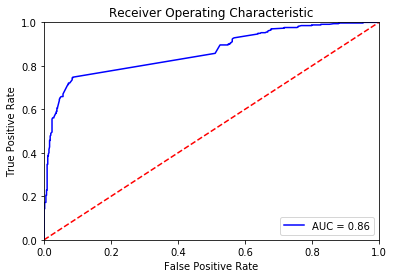

In [8]:
positiveLabel = 'Yes'

naive_bayes = MultinomialNB()
naive_bayes.fit( X_train_cv, y_train )
predictions = naive_bayes.predict( X_test_cv )

print( 'Accuracy score of Naive Bayes: ', accuracy_score( y_test, predictions ) )
print( 'Precision score of Naive Bayes: ', precision_score( y_test, predictions, pos_label = positiveLabel ) )
print( 'Recall score of Naive Bayes: ', recall_score( y_test, predictions, pos_label = positiveLabel ) )
print()
# cm = confusion_matrix( y_test, predictions )
# print( cm )
# df_cm = pd.DataFrame( cm, range( 2 ), range( 2 ) )
# plt.figure(figsize=(10,7))
# sn.set(font_scale=1.4) # for label size
# sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
# plt.imshow( cm )
# plt.show()


# probs = naive_bayes.predict_proba( X_test_cv )
probs = naive_bayes.predict_proba( X_test_cv )
preds = probs[ :, 1 ]
fpr, tpr, threshold = roc_curve( y_test, preds, pos_label = positiveLabel )
roc_auc = auc( fpr, tpr )

plt.title( 'Receiver Operating Characteristic' )
plt.plot( fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc )
plt.legend( loc = 'lower right') 
plt.plot( [ 0, 1 ], [ 0, 1 ], 'r--' )
plt.xlim( [ 0, 1 ] )
plt.ylim( [ 0, 1 ] )
plt.ylabel( 'True Positive Rate' )
plt.xlabel( 'False Positive Rate' )
plt.show()

Accuracy score of Logistic Regression:  0.8180790960451978
Precision score of Logistic Regression:  0.9150943396226415
Recall score of Logistic Regression:  0.5756676557863502


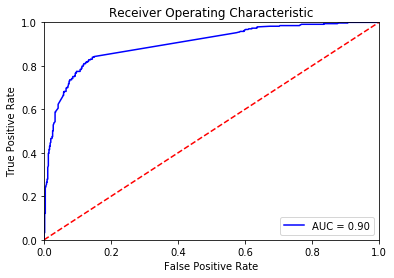

In [9]:
lr = LogisticRegression()
lr.fit( X_train_cv, y_train )
predictions = lr.predict( X_test_cv )

print( 'Accuracy score of Logistic Regression: ', accuracy_score( y_test, predictions ) )
print( 'Precision score of Logistic Regression: ', precision_score( y_test, predictions, pos_label = positiveLabel ) )
print( 'Recall score of Logistic Regression: ', recall_score( y_test, predictions, pos_label = positiveLabel ) )

probs = lr.predict_proba( X_test_cv )
preds = probs[ :, 1 ]
fpr, tpr, threshold = roc_curve( y_test, preds, pos_label = positiveLabel )
roc_auc = auc( fpr, tpr )

plt.title( 'Receiver Operating Characteristic' )
plt.plot( fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc )
plt.legend( loc = 'lower right') 
plt.plot( [ 0, 1 ], [ 0, 1 ], 'r--' )
plt.xlim( [ 0, 1 ] )
plt.ylim( [ 0, 1 ] )
plt.ylabel( 'True Positive Rate' )
plt.xlabel( 'False Positive Rate' )
plt.show()

Accuracy score of Logistic Regression:  0.7932203389830509
Precision score of Logistic Regression:  0.9139784946236559
Recall score of Logistic Regression:  0.5044510385756676


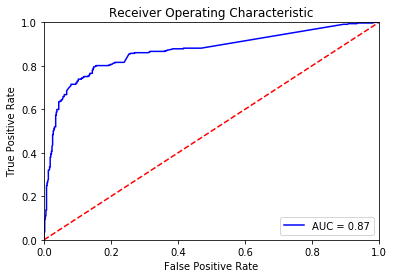

In [10]:
svm = SVC( probability = True )
svm.fit( X_train_cv, y_train )
predictions = svm.predict( X_test_cv )

print( 'Accuracy score of Logistic Regression: ', accuracy_score( y_test, predictions ) )
print( 'Precision score of Logistic Regression: ', precision_score( y_test, predictions, pos_label = positiveLabel ) )
print( 'Recall score of Logistic Regression: ', recall_score( y_test, predictions, pos_label = positiveLabel ) )

probs = svm.predict_proba( X_test_cv )
preds = probs[ :, 1 ]
fpr, tpr, threshold = roc_curve( y_test, preds, pos_label = positiveLabel )
roc_auc = auc( fpr, tpr )

plt.title( 'Receiver Operating Characteristic' )
plt.plot( fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc )
plt.legend( loc = 'lower right') 
plt.plot( [ 0, 1 ], [ 0, 1 ], 'r--' )
plt.xlim( [ 0, 1 ] )
plt.ylim( [ 0, 1 ] )
plt.ylabel( 'True Positive Rate' )
plt.xlabel( 'False Positive Rate' )
plt.show()